<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x02_%E7%BA%BF%E6%80%A7%E5%9B%9E%E5%BD%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 1.生成数据集
我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 X∈R1000×2X∈R 
1000×2
 ，我们使用线性回归模型真实权重 w=[2,−3.4]⊤w=[2,−3.4] 
⊤
  和偏差 b=4.2b=4.2，以及一个随机噪声项$\epsilon$来生成标签
  y=xw+b+$\epsilon$
  其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples=1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.randn(num_examples,num_inputs,dtype=torch.float32)
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

注意，features的每一行是一个长度为2的向量，而labels的每一行是一个长度为1的向量（标量）。

In [3]:
print(features[0],labels[0])

tensor([-2.0762, -0.3519]) tensor(1.2446)


通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系。

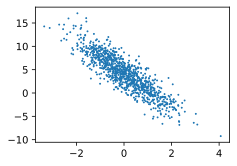

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


## 2.读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [5]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(num_examples,i+batch_size)])
        yield features.index_select(0,j),labels.index_select(0,j)

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.4457, -0.7352],
        [-0.9573, -0.2861],
        [-1.0464,  1.2510],
        [ 0.0702, -0.8865],
        [ 0.6061,  0.1803],
        [ 0.0451, -0.5216],
        [-0.2448,  1.6181],
        [-0.1907,  0.9478],
        [ 0.6813, -0.5958],
        [ 0.8964,  0.1525]]) tensor([ 5.8048,  3.2540, -2.1490,  7.3578,  4.7893,  6.0731, -1.7940,  0.5810,
         7.5894,  5.4672])


## 3.初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [7]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)

In [8]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

In [9]:
print(w)

tensor([[0.0025],
        [0.0012]], requires_grad=True)


## 4.定义模型

下面是线性回归的矢量计算表达式的实现。我们使用mm函数做矩阵乘法。

In [10]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

## 5.定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同。

In [11]:
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size())) ** 2 / 2

## 6.定义优化算法

以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [12]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -= lr*param.grad/batch_size

## 7.训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量，再运行l.backward()得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）
    # X和y分别是小批量样本的特征和标签
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()# 小批量的损失对模型参数求梯度
        sgd([w,b],lr,batch_size) # 使用小批量随机梯度下降迭代模型参数
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.034796
epoch 2, loss 0.000121
epoch 3, loss 0.000048


In [14]:
print(true_w, '\n', w)
print(true_b, '\n', b)


[2, -3.4] 
 tensor([[ 1.9995],
        [-3.4000]], requires_grad=True)
4.2 
 tensor([4.1998], requires_grad=True)
